<a href="https://colab.research.google.com/github/Roman3173/RomanGo/blob/main/Test%20cases/Gett%20(taxi)/Matching_Home_Assignment_for_Candidates_(ru).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Тестовое задание в команду продуктовой аналитики, Gett.

Взято из https://github.com/slgero/testovoe/tree/master/Gett

В папке с заданием два датасета - data_orders - содержит выборку данных по заказам пользователей и включает такие колонки как:
* order_datetime -  время заказа
* origin_longitude - долгота
* origin_latitude - широта
* m_order_eta - время до прибытия машины
* order_gk - номер заказа
* order_status_key - статус (4 - отменен клиентом, 9 - отменен системой (reject))
* is_driver_assigned_key - был ли назначен водитель
* cancellations_time_in_seconds - сколько секунд прошло до отмены

data_offers - содержит пары номер заказа - ID оффера, который был предложен водителю по данному заказу.


В момент когда клиент нажимать на кнопку "Заказать" в приложении, система матчинга подыскивает наиболее релевантых водителей и предлагаем им заказ. В задании предлагается исследовать некоторые метрики матчинга для заказов, которые не завершились успешно (клиент в итоге не получил машину).

# Подготовка и оценка данных

In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [58]:
!wget https://raw.githubusercontent.com/slgero/testovoe/master/Gett/data/data_offers.csv
# offers = pd.read_csv("https://drive.google.com/file/d/1jWx4iltlvq-_R3ZfGIPX0j8vl0Q3KX2q/view?usp=drive_link")

--2024-01-23 18:04:37--  https://raw.githubusercontent.com/slgero/testovoe/master/Gett/data/data_offers.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9027819 (8.6M) [text/plain]
Saving to: ‘data_offers.csv.1’

data_offers.csv.1   100%[===================>]   8.61M  --.-KB/s    in 0.1s    

2024-01-23 18:04:37 (90.5 MB/s) - ‘data_offers.csv.1’ saved [9027819/9027819]



In [59]:
!wget https://raw.githubusercontent.com/slgero/testovoe/master/Gett/data/data_orders.csv
# df = pd.read_csv("https://drive.google.com/file/d/14-tR7qr7lb97bEd5Q6LE9NPLoD0W8RWt/view?usp=drive_link")

--2024-01-23 18:04:37--  https://raw.githubusercontent.com/slgero/testovoe/master/Gett/data/data_orders.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 571786 (558K) [text/plain]
Saving to: ‘data_orders.csv.1’

data_orders.csv.1   100%[===================>] 558.38K  --.-KB/s    in 0.04s   

2024-01-23 18:04:37 (13.0 MB/s) - ‘data_orders.csv.1’ saved [571786/571786]



In [60]:
df = pd.read_csv("/content/data_orders.csv")
offers = pd.read_csv("/content/data_offers.csv")

In [61]:
# сначала проверить потенциально менее информативный csv
offers.head(5)

,order_gk,offer_id
0,3000579625629,300050936206
1,3000627306450,300052064651
2,3000632920686,300052408812
3,3000632771725,300052393030
4,3000583467642,300051001196


In [62]:
# пропуски отсутствуют
offers.isna().sum()

order_gk    0
offer_id    0
dtype: int64

In [63]:
# уникальных значений "order_gk" значительно больше, чем среди отменённых.
offers.nunique()

order_gk     97967
offer_id    334363
dtype: int64

In [64]:
# так или иначе отменено примерно 10.6% заказов (не состоявшихся заказов скорее всего меньше)
total_orders = pd.concat([offers['order_gk'], df['order_gk']], ignore_index = True).nunique()
df['order_gk'].nunique() / total_orders

0.10602237986405864

In [65]:
# 3106 значений из отменённых orders не имеют ни одного offer
total_orders - offers['order_gk'].nunique()

3106

In [66]:
# первый взгляд на основной датасет
df.head(5)

,order_datetime,origin_longitude,origin_latitude,m_order_eta,order_gk,order_status_key,is_driver_assigned_key,cancellations_time_in_seconds
0,18:08:07,-0.978916,51.456173,60.0,3000583041974,4,1,198.0
1,20:57:32,-0.950385,51.456843,NaN,3000583116437,4,0,128.0
2,12:07:50,-0.969520,51.455544,477.0,3000582891479,4,1,46.0
3,13:50:20,-1.054671,51.460544,658.0,3000582941169,4,1,62.0
4,21:24:45,-0.967605,51.458236,NaN,3000583140877,9,0,NaN


In [67]:
# проверяем процент пропущенных данных
df.isna().mean()
#df.isna().sum()

order_datetime                   0.000000
origin_longitude                 0.000000
origin_latitude                  0.000000
m_order_eta                      0.737402
order_gk                         0.000000
order_status_key                 0.000000
is_driver_assigned_key           0.000000
cancellations_time_in_seconds    0.318122
dtype: float64

In [68]:
# проверяем числовые переменные
df.describe()

,origin_longitude,origin_latitude,m_order_eta,order_gk,order_status_key,is_driver_assigned_key,cancellations_time_in_seconds
count,10716.000000,10716.000000,2814.000000,1.071600e+04,10716.000000,10716.000000,7307.000000
mean,-0.964323,51.450541,441.415423,3.000598e+12,5.590612,0.262598,157.892021
std,0.022818,0.011984,288.006379,2.396261e+07,2.328845,0.440066,213.366963
min,-1.066957,51.399323,60.000000,3.000550e+12,4.000000,0.000000,3.000000
25%,-0.974363,51.444643,233.000000,3.000583e+12,4.000000,0.000000,45.000000
50%,-0.966386,51.451972,368.500000,3.000595e+12,4.000000,0.000000,98.000000
75%,-0.949605,51.456725,653.000000,3.000623e+12,9.000000,1.000000,187.500000
max,-0.867088,51.496169,1559.000000,3.000633e+12,9.000000,1.000000,4303.000000


In [69]:
# проверяем предположение, что "order_gk" -- primary key, проверяем уникальность значений
n = df['order_gk'].nunique()
n

10716

In [70]:
# проверяем, всё ли в датафрейме -- отказы, а также типы отказов.
df.groupby('order_status_key')['order_gk'].count()

order_status_key
4    7307
9    3409
Name: order_gk, dtype: int64

In [71]:
# проверяем какие данные достались в таймстемпе "order_datetime"
df['order_datetime'].sort_values()

832      00:00:02
7858     00:00:03
10091    00:00:05
9919     00:00:11
5060     00:00:16
           ...   
3930     23:59:34
3637     23:59:40
8077     23:59:42
1968     23:59:47
1270     23:59:59
Name: order_datetime, Length: 10716, dtype: object

In [72]:
# для будущих заданий полезно создать столбец "hour", а также сразу проверить разбиение заказов
df['hour'] = pd.to_datetime(df['order_datetime'],format='%H:%M:%S').dt.hour

<Axes: xlabel='hour'>

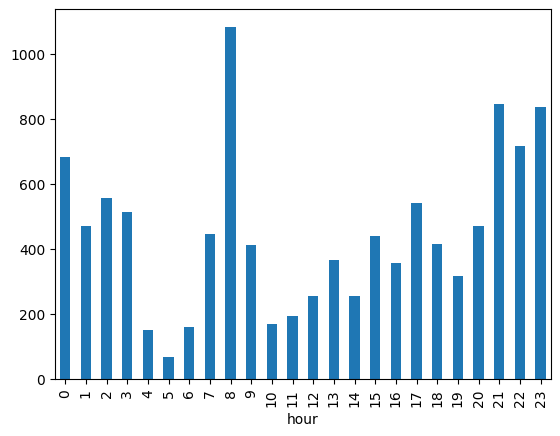

In [73]:
df.groupby('hour')['order_datetime'].count().plot(kind = 'bar')

Первичная оценка данных:

1. data_orders.csv - основной датафрейм.
2. из интересного по data_offers.csv: подсчитано, что отменённых заказов -- лишь 10.6% от общего числа (не состоявшихся заказов явно меньше, так как никто не может запретить пользователю сделать ещё один запрос при отмене первого по любой причине).
2. order_gk - primary key датафрейма (unique id)
3. order_status_key - все заказы имеют либо статус 4, либо 9, без пропусков или иных значений
4. Нам дано только время заказа (без даты). Скорее всего данные выгружены за период (минимум за неделю), так как:
* разбиение по часам демонстрирует, что есть пик в 7-9 часов утра (клиенты едут на работу, характерно для будней),
* дальше спад и постепенный рост вплоть до конца дня, что характерно для пятницы или выходных;
* также наблюдается большая активность в первой половине ночи (0-3 часа), что не характерно для начала пятницы (четверг, конечно, маленькая пятница, но не настолько).

Если предположение "в датафрейме данные за будни и выходные -- смешаны" -- верно, то их всё ещё можно анализировать, но выводы не в полной мере достоверны: поведение пользователей (как клиентов, так и таксистов) и загруженность в будни и выходные должны сильно отличаться друг от друга, а значит и отказы (системные или пользовательские) должны также различаться. В условиях работы в компании информацию по данным лучше уточнить у выгрузивших их специалистов (что в рамках тестового задания, скачанного из интернета, сделать невозможно). Имеем что имеем.

# 1 задание: постройте распределение заказов по причинам неуспеха
отмены до и после назначения водителя, режекты

Проанализируйте полученный график - в какой категории наибольшое количество заказов?

In [74]:
# n -- общее число отменённых заказов
t = (df.groupby(['is_driver_assigned_key', 'order_status_key'])['order_gk'].count()).reset_index()
t['mean']          = t['order_gk'] / n
t['total_percent'] = t['order_gk'] / total_orders
t

,is_driver_assigned_key,order_status_key,order_gk,mean,total_percent
0,0,4,4496,0.419560,0.044483
1,0,9,3406,0.317842,0.033698
2,1,4,2811,0.262318,0.027812
3,1,9,3,0.000280,0.000030


Нет смысла строить график.
* 74% заказов отменено, когда водитель НЕ назначен.
* Из которых больше половины (42% отказов, 4.4% заказов) -- отменял клиент (видимо, не хватило терпения).
* 32% отказов и 3.3% от общего числа заказов прерывала система: скоре всего, не получалось подобрать водителя за установленное время.
* когда водитель найден, отмена почти наверняка инициализируется клиентом (26% отказов, 2.8% заказов). Скорее всего самый частый сценарий: либо водитель долго едет, либо время до его приезда слишком велико.
* 3 случая отмены со стороны системы уже после назначения водителя стоит изучить отдельно вне рамок текущего исследования (если это не будет избыточно затратно, всё же слишком редки случаи).

# 2 задание: постройте график распределения фейлов по часам
Наблюдается ли тендеция, что в какие то часы доля той или иной категории аномально высока?

<Axes: xlabel='hour'>

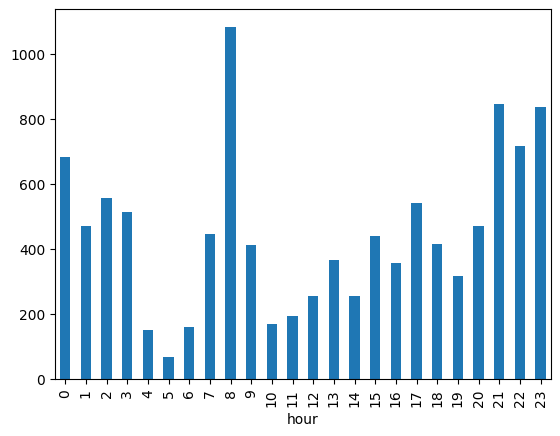

In [75]:
df.groupby('hour')['order_status_key'].count().plot(kind = 'bar')

В какие часы фейлов больше всего? Чем это можно объяснить?

Отказов больше всего в утренние часы, а также вечером и ночью. Если верно предположение, что исходные данные -- это слитые воедино данные за период, допустим, от недели и более, то:
* пик с 7 до 9 -- это повышенный спрос в утренний час пик будних дней;
* пик с 20 до 3 ночи -- это повышенный спрос в выходные дни.

Главные предположение:
* чем больше заказов -- тем больше отказов;
* чем дольше поиск водителя -- тем выше вероятность отказа;
* чем дольше будет ехать водитель -- тем выше вероятность отказа.

У нас отсутствуют данные по успешным заказам, поэтому подтвердить первое утверждение мы не можем. Остальные так или иначе обработаются в следующих заданиях.

# 3 задание: постройте графики среднего времени до отмены (cancellations_time_in_seconds) с водителем и без, по часам.
Если есть выбросы в данных - лучше удалить. Можно ли сделать выводы по этому графику?

In [76]:
# Если заказ отменён системой, то "cancellations_time_in_seconds" -- не определено. То есть исследовать будем сугубо заказы, отменённые клиентом.
(~df[df['order_status_key'] == 9]['cancellations_time_in_seconds'].isna()).sum()

0

In [77]:
df[df['order_status_key'] == 4]['cancellations_time_in_seconds'].isna().sum()

0

In [78]:
# t -- без водителя
def percentile(n):
    def percentile_(x):
        return x.quantile(n)
    percentile_.__name__ = 'percentile_{:02.0f}'.format(n*100)
    return percentile_
t = df[(df['is_driver_assigned_key'] == 0) & (df['order_status_key'] == 4)].groupby('hour')['cancellations_time_in_seconds'].agg(['count','mean','median',percentile(0.25),percentile(0.75)])
temp = df[df['is_driver_assigned_key'] == 0]['cancellations_time_in_seconds']
t['mean_global'] = temp.mean()
t['median_global'] = temp.median()
t['percentile_25_global'] = temp.quantile(0.25)
t['percentile_75_global'] = temp.quantile(0.75)
#t[['count', 'mean', 'median', 'percentile_25', 'percentile_75']]

In [79]:
# t2 -- с водителем
t2 = df[df['is_driver_assigned_key'] == 1 & (df['order_status_key'] == 4)].groupby('hour')['cancellations_time_in_seconds'].agg(['count','mean','median',percentile(0.25),percentile(0.75)])
temp = df[df['is_driver_assigned_key'] == 1]['cancellations_time_in_seconds']
t2['mean_global'] = temp.mean()
t2['median_global'] = temp.median()
t2['percentile_25_global'] = temp.quantile(0.25)
t2['percentile_75_global'] = temp.quantile(0.75)
#t2[['count', 'mean', 'median', 'percentile_25', 'percentile_75']]

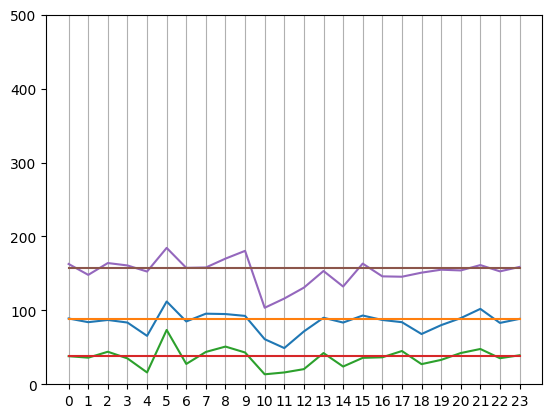

In [80]:
# квантили без водителя
plt.xticks(np.arange(0, 24, 1.0))
plt.ylim([0,500])
plt.grid (axis='x')
plt.plot(t[['median',	'median_global', 'percentile_25',	'percentile_25_global',	'percentile_75', 'percentile_75_global']])
#t[['median',	'median_global', 'percentile_25',	'percentile_25_global',	'percentile_75', 'percentile_75_global']].plot(legend=False)
#t2[['median',	'median_global', 'percentile_25',	'percentile_25_global',	'percentile_75', 'percentile_75_global']].plot(legend=False)

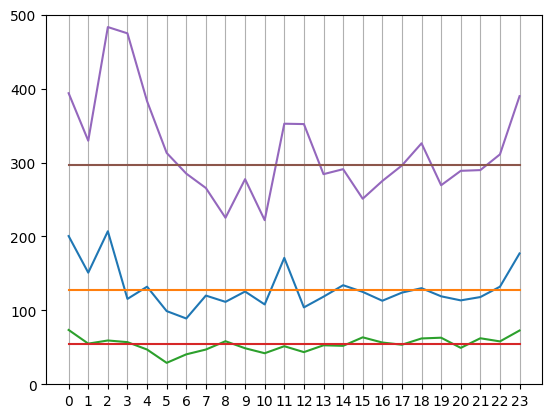

In [81]:
# квантили с водителем
plt.ylim([0,500])
plt.xticks(np.arange(0, 24, 1.0))
plt.grid (axis='x')
plt.plot(t2[['median',	'median_global', 'percentile_25',	'percentile_25_global',	'percentile_75', 'percentile_75_global']])

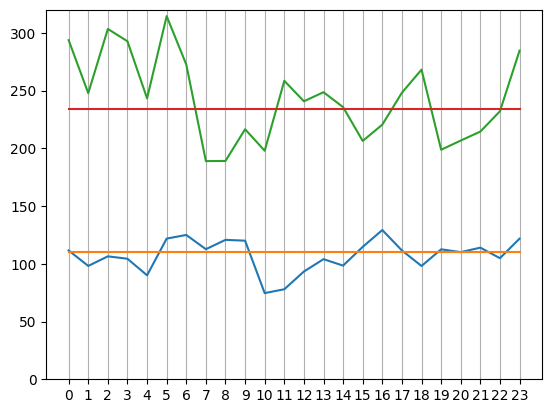

In [82]:
# верхний график -- водитель определён, нижний -- нет
plt.ylim([0,320])
plt.xticks(np.arange(0, 24, 1.0))
plt.grid (axis='x')
plt.plot(pd.merge(t[['mean', 'mean_global']], t2[['mean','mean_global']], left_index=True, right_index=True))
#t[['mean', 'mean_global']].plot(legend=False)
#t2[['mean','mean_global']].plot()

Я решил не удалять выбросы, а посмотреть не только среднее значение, но и квантили.

Несколько выводов:
* Если заказ был отменён системой ("**order_status_key**" == 9), то "**cancellations_time_in_seconds**" не определено. То есть рассматриваются только случаи, когда заказ отменён пользователем.
* Если водитель НЕ был определён:
  * как в среднем, так и по квантилям поездка отменяется значительно быстрее, чем когда водитель БЫЛ определён;
  * изменения средних значений и квантилей напоминают друг друга, наблюдаются отклонение в большую сторону в 5 утра (особенно по квантилям) и в меньшую сторону в 10-11 утра. Эти отклонения могут быть связаны как с тем, что в эти промежутки времени наименьшее число отказов и, возможно, в целом заказов (смотри задание 2) или больше свободных водителей, так и специфичным поведением людей, которые куда-то едут в 5 утра и в середине рабочего дня.
* Если водитель БЫЛ определён:
  * среднее по часам имеет куда более хаотичный разброс, нежели квантили (на лицо наличие выбросов);
  * с 23 до 5 утра пользователи готовы ждать (прежде, чем откажутся от поездки) автомобиль дольше, чем в любой другой промежуток времени. Скорее всего это данные в основном выходных дней. В таком случае способность дольше подождать обусловлена необходимостью вернуться домой в условиях недоступности городского транспорта, также на большее ожидание сказывается результат следующего задания: в поздние часы меньше время до прибытия автомобиля, а значит пользователь дольше сохраняет надежду.

# 4 задание: Постройте распределение среднего ЕТА по часам.
Чем можно объяснить такой вид графика?

In [83]:
# "m_order_eta" не определено, если водитель не назначен
(~df[df['is_driver_assigned_key'] == 0]['m_order_eta'].isna()).sum()

0

In [84]:
( df[df['is_driver_assigned_key'] == 1]['m_order_eta'].isna()).sum()

0

In [85]:
t3 = df[df['is_driver_assigned_key'] == 1].groupby('hour')[['m_order_eta']].mean()
t3['mean'] = df['m_order_eta'].mean()

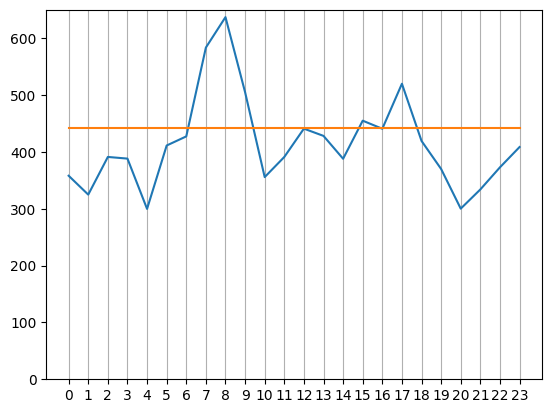

In [86]:
plt.ylim([0,650])
plt.xticks(np.arange(0, 24, 1.0))
plt.grid (axis='x')
plt.plot(t3)

1. Если водитель не назначен, то и время ETA не определено. Значит анализируем только с назначенным водителем.
2. Утром в будние дни с 7 до 9 повышенный спрос + наиболее загружены дороги, поэтому и такси прибудет далеко не сразу
3. Вечером и ночью дорожный трафик в среднем куда более разрежен. Также в условиях выходных дней обычно выходит повышенное количество водителей (люди выходят на подработку + стимуляция через повышенные тарифы).

# 5 задание:  Постройте часовую разбивку среднего количества водителей которым был предложен заказ.
Колонка drivers_offered - показывает сколько водителей увидели заказ и могли его принять. Что можно сказать по ней про избыток/нехватку водителей в те или иные часы?

In [87]:
t4 = offers.groupby('order_gk')['offer_id'].count().reset_index()
df = df.merge(t4, how = 'left', on = 'order_gk')

In [88]:
df.head(5)

,order_datetime,origin_longitude,origin_latitude,m_order_eta,order_gk,order_status_key,is_driver_assigned_key,cancellations_time_in_seconds,hour,offer_id
0,18:08:07,-0.978916,51.456173,60.0,3000583041974,4,1,198.0,18,1.0
1,20:57:32,-0.950385,51.456843,NaN,3000583116437,4,0,128.0,20,3.0
2,12:07:50,-0.969520,51.455544,477.0,3000582891479,4,1,46.0,12,6.0
3,13:50:20,-1.054671,51.460544,658.0,3000582941169,4,1,62.0,13,3.0
4,21:24:45,-0.967605,51.458236,NaN,3000583140877,9,0,NaN,21,NaN


In [89]:
# 3106 у прерванных заказов, которые не были предложены ни одному водителю, полной корреляции ни с одним из статусов не наблюдается
df[df['offer_id'].isna()].head(5)

,order_datetime,origin_longitude,origin_latitude,m_order_eta,order_gk,order_status_key,is_driver_assigned_key,cancellations_time_in_seconds,hour,offer_id
4,21:24:45,-0.967605,51.458236,NaN,3000583140877,9,0,NaN,21,NaN
7,07:53:46,-0.978230,51.454575,NaN,3000582791562,9,0,NaN,7,NaN
13,16:55:28,-0.950683,51.451368,538.0,3000583016613,4,1,188.0,16,NaN
15,00:04:16,-0.974519,51.454603,NaN,3000582541301,9,0,NaN,0,NaN
19,08:49:02,-0.963172,51.454195,NaN,3000582817399,9,0,NaN,8,NaN


In [90]:
# распределение в других пропорциях, но напоминает распределение из 1 задания
df[df['offer_id'].isna()].groupby(['order_status_key', 'is_driver_assigned_key'])['order_gk'].count()

order_status_key  is_driver_assigned_key
4                 0                         1129
                  1                          473
9                 0                         1503
                  1                            1
Name: order_gk, dtype: int64

In [91]:
# количество увидевших заказ водителей без явных выбросов распределено от 1 до 9
df.groupby('offer_id')['order_gk'].count()

offer_id
1.0    1461
2.0     914
3.0    1202
4.0     997
5.0     726
6.0     755
7.0     647
8.0     476
9.0     432
Name: order_gk, dtype: int64

In [92]:
t5 = df[~df['offer_id'].isna()].groupby('hour')[['offer_id']].mean()
t5['mean'] = df[~df['offer_id'].isna()]['offer_id'].mean()

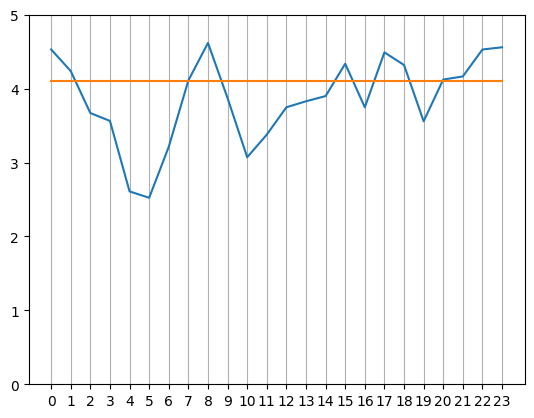

In [93]:
plt.ylim([0,5])
plt.xticks(np.arange(0, 24, 1.0))
plt.grid (axis='x')
plt.plot(t5)

1. 3106 заказов не было представлено ни одному водителю. Среди них есть как заказы, которым назначены водители, так и нет; как отменённые пользователем, так и системой, есть заказы с определённым временем поездки и временем до отказа. Скорее всего это как-то связано с водителями, удалёнными из системы.
2. Наблюдаются просадки по количеству водителей, которым поступил заказ в 2-6 и в 10-13 часов. Скорее всего это связано с тем, что в эти часы много свободных водителей и не так много клиентов, поэтому заказы разбираются очень быстро. Это также отчасти пересекается с результатами задания 4.

# 6 задание: Гексаконы.
Воспользовавшись пакетами h3 и folium, посчитайте, сколько гексагонов размера 8 (https://uber.github.io/h3/#/documentation/core-library/resolution-table) содержат 80% всех заказов из исходного датасета и визуализируйте гексагон с наибольшим количеством фейлов на карте.

In [94]:
! pip install h3

In [95]:
import h3

In [96]:
def get_hexagram(row):
    return h3.geo_to_h3(row['origin_latitude'], row['origin_longitude'], 8)

In [97]:
df['hexagram'] = df.apply(get_hexagram, axis = 1)

In [98]:
(df['hexagram'].value_counts() / n).cumsum().head(24)

88195d2b1dfffff    0.139698
88195d2b1bfffff    0.220885
88195d2b15fffff    0.293113
88195d2b11fffff    0.359089
88195d2b19fffff    0.421333
88195d284dfffff    0.482270
88195d2a27fffff    0.520903
88195d2b0bfffff    0.555618
88195d2a25fffff    0.589399
88195d2b13fffff    0.621687
88195d2b03fffff    0.645670
88195d2b17fffff    0.665267
88195d2b39fffff    0.682437
88195d2861fffff    0.699421
88195d2a21fffff    0.713979
88195d2b3dfffff    0.728257
88195d2b31fffff    0.741601
88195d2869fffff    0.753266
88195d2b3bfffff    0.763998
88195d2b51fffff    0.773143
88195d2b57fffff    0.781728
88195d2a23fffff    0.790220
88195d2b55fffff    0.798152
88195d2b09fffff    0.805711
Name: hexagram, dtype: float64

Ответ: на 24 гексагона приходится 80% отклонённых заказа

In [99]:
top_hex = df['hexagram'].value_counts().index[0]
t6 = df[df['hexagram'] == top_hex][['origin_longitude', 'origin_latitude']]
t6

,origin_longitude,origin_latitude
2,-0.969520,51.455544
4,-0.967605,51.458236
22,-0.972037,51.456781
24,-0.973763,51.458671
37,-0.971564,51.458022
...,...,...
10699,-0.971480,51.458364
10700,-0.973398,51.458384
10705,-0.972926,51.457693
10713,-0.972926,51.457693


In [100]:
lat_max = t6['origin_latitude'].max()
lat_min = t6['origin_latitude'].min()

lon_max = t6['origin_longitude'].max()
lon_min = t6['origin_longitude'].min()
lat_max

51.461086

In [101]:
coords = t6.values

In [102]:
import folium

In [103]:
# наносим точки на карту
m = folium.Map(location=(51.45670132891814, -0.9698197671953651), zoom_start = 15)
for i in range(len(coords)):
    folium.CircleMarker(
        location = [coords[i][1], coords[i][0]],
        fill = True,
        fill_color = 'red',
        color = 'red',
        radius = 1
    ).add_to(m)

In [104]:
# отрисовываем гексогон
trail_coordinates = [
    (lat_max, -0.973),
    (lat_max, -0.964),
    ((lat_max + lat_min) / 2, -0.960),
    (lat_min, -0.964),
    (lat_min, -0.973),
    ((lat_max + lat_min) / 2, -0.977),
    (lat_max, -0.973),
]

folium.PolyLine(trail_coordinates, tooltip="Coast").add_to(m)

In [105]:
# гексагон нарисован не совсем красиво, но вполне достаточно
m

Ответ: 80% отклонённых заказов приходится на 24 гексагона.

Точки и гексагон на карту нанесены: центр Reading'а, что близ Лондона.